# Training Consistency Models on FashionMNIST using miniai

## Imports

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
from miniai.imports import *
from miniai.diffusion import *
from diffusers import UNet2DModel
from fastprogress import progress_bar
from glob import glob
from copy import deepcopy

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

Use HuggingFace Datasets to load the Fashion MNIST dataset.

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/home/tmabraham/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

Noisification based on Karras et al.

In [ ]:
sig_data=0.5

def scalings(sig,eps):
    # c_skip,c_out,c_in
    return sig_data**2/((sig-eps)**2+sig_data**2),(sig-eps)*sig_data/(sig**2+sig_data**2).sqrt(),1/((sig-eps)**2+sig_data**2).sqrt()

In [ ]:
def sigmas_karras(n, sigma_min=0.002, sigma_max=80., rho=7.):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return sigmas.cuda()

Create DataLoaders:

In [ ]:
def collate_consistency(b): return default_collate(b)[xl]
def dl_consistency(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_consistency, num_workers=8)

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_consistency(tds['train']), dl_consistency(tds['test']))

## Consistency model

Model parameterization as described in the paper:
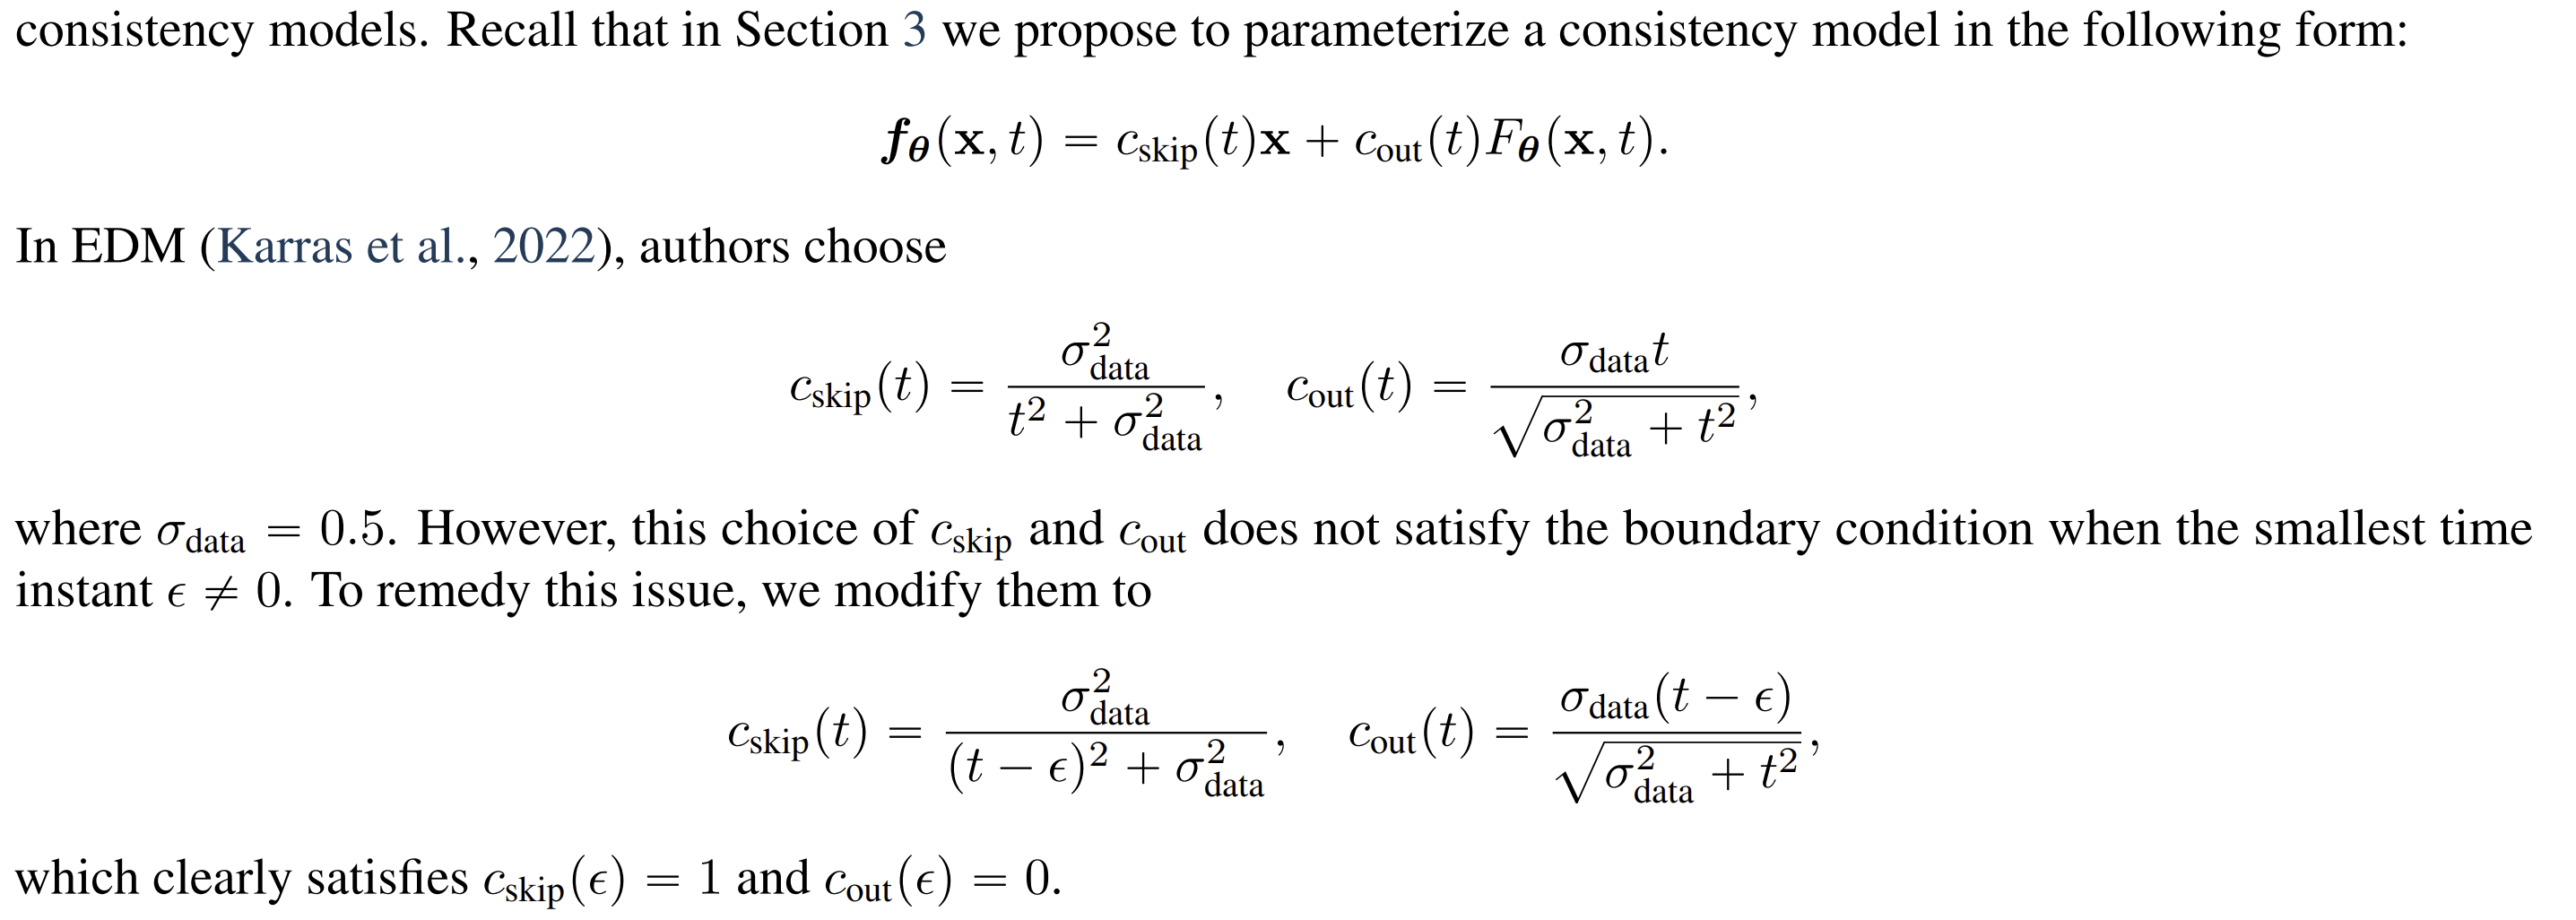

In [ ]:
class ConsistencyUNet(nn.Module):
    def __init__(self, eps, model):
        super().__init__()
        self.eps = eps
        self.F = model 
        
    def forward(self, inp):
        x,sig = inp
        c_skip,c_out,c_in = scalings(sig.reshape(-1,1,1,1),self.eps)
        return c_skip*x + c_out*self.F((x,sig.squeeze()))#.squeeze(-1).squeeze(-1)))

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

miniai Callback for Consistency Model training. 

Before training, create EMA model.

During each batch of training, calculate maximum timestep based on the adaptive N schedule. Our new batch is now $((\mathbf{x}_n,\sigma_n),(\mathbf{x}_{n+1},\sigma_{n+1}))$. The second tuple is passed into the EMA model while the first is passed into the regular model and the loss is the MSE between both of these outputs. 

Finally, the EMA model is updated.

In [ ]:
class ConsistencyCB(TrainCB):
    def __init__(self, N=150):
        super().__init__()
        self.N=N
    
    def before_fit(self, learn): 
        self.ema_model = deepcopy(learn.model)
        self.ema_model.load_state_dict(learn.model.state_dict())
        
    def before_batch(self, learn):
        self.N = math.ceil(math.sqrt((learn.epoch+1 * (self.N**2 - 4) / learn.n_epochs) + 4) - 1) + 1
        noise_sched = sigmas_karras(self.N).flip(dims=(-1,))
        x0 = learn.batch # original images, x_0
        device = x0.device
        t = torch.randint(self.N-1,[len(x0)])
        t_1 = t+1
        sig_n = noise_sched[t].reshape(-1,1,1,1).to(device)
        sig_n_1 = noise_sched[t_1].reshape(-1,1,1,1).to(device)
        z = torch.randn_like(x0, device=device)
        noised_input_n = x0 + sig_n*z
        noised_input_n_1 = x0 + sig_n_1*z
        learn.batch = (noised_input_n,sig_n),(noised_input_n_1,sig_n_1)#.squeeze())
    def predict(self, learn): 
        with torch.no_grad(): learn.preds = self.ema_model(*learn.batch[:self.n_inp])   
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, learn.model(*learn.batch[self.n_inp:]))
    def after_step(self, learn):
        with torch.no_grad():
            mu = math.exp(2 * math.log(0.95) / self.N)
            # update \theta_{-}
            for p, ema_p in zip(learn.model.parameters(), self.ema_model.parameters()):
                ema_p.mul_(mu).add_(p, alpha=1 - mu)

Setup and start training:

In [ ]:
lr = 3e-5
epochs = 100
opt_func = optim.AdamW
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), ConsistencyCB()]
model = ConsistencyUNet(0.002,UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)) 
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.269,0,train
0.218,0,eval
0.205,1,train
0.201,1,eval
0.201,2,train
0.198,2,eval
0.162,3,train
0.133,3,eval
0.133,4,train
0.133,4,eval


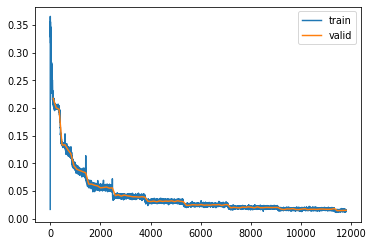

In [ ]:
learn.fit(epochs)

## Sampling

In [ ]:
import gc
gc.collect()

8678

In [ ]:
torch.cuda.empty_cache()

Sampling with one-step is extremely simple 😉

In [ ]:
def one_step_sample(model,sz):
    sig = sigmas_karras(learn.cbs[-1].N).flip(dims=(-1,))[-1] # get the max variance
    x = torch.randn(sz).cuda() * sig # create noise
    sig = sig[None] * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1) # reshape it appropriately
    return model((x,sig)) # simply return model output

In [ ]:
sz = (512, 1, 32, 32)

In [ ]:
s = one_step_sample(learn.model,sz)

You can see our samples are not perfect, but impressive for a single step!

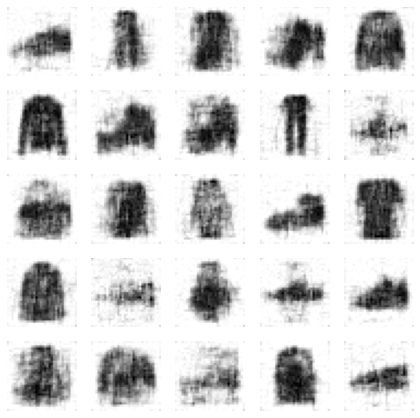

In [ ]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

We can refine with the multi-step algorithm too. Here I just choose some seemingly appropriate timesteps, the original paper actually uses a greedy algorithm to optimize the timepoints used to get the best FID (although details on this seems minimal IMO).

In [ ]:
x=s
for sig in reversed([5.0, 10.0, 20.0, 40.0]):
    print(sig)
    z = torch.randn_like(x)
    x = x + math.sqrt((sig)**2 - learn.model.eps**2) * torch.randn(sz).cuda()
    x = learn.model((x, tensor(sig)[None].cuda() * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1)))
    gc.collect()
    torch.cuda.empty_cache()
s=x

40.0
20.0
10.0
5.0


Outputs still a little noisy, but quite good for 5 steps!

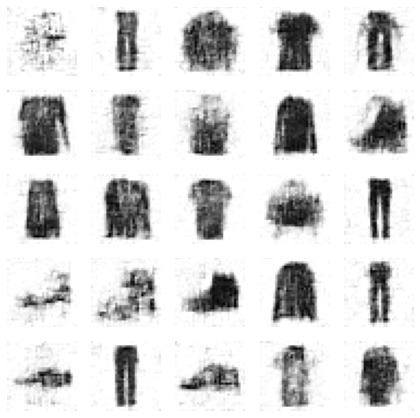

In [ ]:
show_images(s[:25].clamp(-1,1), imsize=1.5)